In [1]:
cd ../..

c:\Users\Josu\Documents\Workspace\Human-Benchmark\src\server\model


In [13]:
import glob
from datetime import datetime

import chess
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scripts.utils import absolute_bitboard
from tensorflow.keras import callbacks, utils

from models import DeepChess

In [3]:
XX, yy = [], []
for file in glob.glob("data/npz/*.npz"):
    with np.load(file) as f:
        XX.append(f["X"]), yy.append(f["y"])
X, y = np.concatenate(XX), np.concatenate(yy)

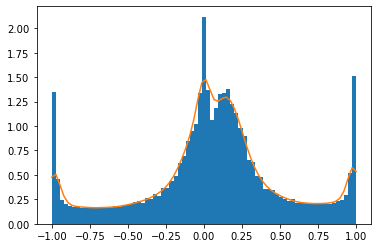

In [4]:
_, x, _ = plt.hist(y, bins=75, density=True)  
ax = plt.plot(x,  stats.gaussian_kde(y)(x))

In [5]:
model = DeepChess()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8, 8, 6)]    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 8, 8, 128)    7040        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 8, 128)    147584      conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 8, 128)    147584      conv2d_1[0][0]                   
______________________________________________________________________________________________

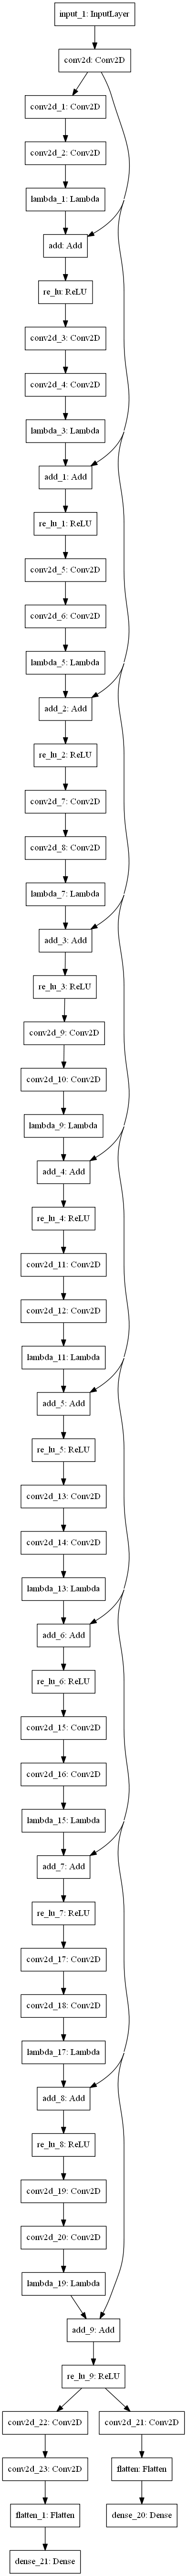

In [8]:
utils.plot_model(model, to_file=f"models/logs/{datetime.now().strftime('%Y%m%d-%H%M%S')}")

In [15]:
callback = callbacks.TensorBoard(log_dir=f"models/logs/{datetime.now().strftime('%Y%m%d-%H%M%S')}")

In [22]:
model.compile(
    optimizer="adam",
    loss="mae",
    metrics=["accuracy"]
)

In [23]:
_ = model.fit(
    x=X,
    y=y,
    batch_size=32,
    epochs=5,
    callbacks=(callback,),
    validation_split=0.2
)

Epoch 1/5
9819/9819 [==============================] - 140s 14ms/step - loss: 0.7675 - accuracy: 0.3131 - val_loss: 0.7196 - val_accuracy: 0.3171
Epoch 2/5
9819/9819 [==============================] - 134s 14ms/step - loss: 0.7208 - accuracy: 0.3615 - val_loss: 0.7134 - val_accuracy: 0.3398
Epoch 3/5
9819/9819 [==============================] - 137s 14ms/step - loss: 0.7106 - accuracy: 0.3672 - val_loss: 0.6902 - val_accuracy: 0.3701
Epoch 4/5
9819/9819 [==============================] - 134s 14ms/step - loss: 0.7039 - accuracy: 0.3702 - val_loss: 0.6881 - val_accuracy: 0.3577
Epoch 5/5
9819/9819 [==============================] - 143s 15ms/step - loss: 0.6989 - accuracy: 0.3731 - val_loss: 0.6811 - val_accuracy: 0.3581


In [46]:
model.predict(
    np.array([
        absolute_bitboard(
            chess.Board("1nbqkbnr/rppppppp/8/p7/3PP3/5N2/PPP2PPP/RNBQKB1R b KQk - 0 1")
        )
    ])
)

array([[0.9999661]], dtype=float32)